## Importing all the important Libraries

In [120]:
import torch
from torch import nn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
print(f"The version of torch is {torch.__version__}")

The version of torch is 2.9.0+cpu


###1.1 Device agnostic code

In [121]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [122]:
# Creating the moon dataset


# Hyperparameters
NUM_SAMPLES = 1000
RANDOM_SEED=42

# Data Creation
X_moon, y_moon = make_moons(n_samples=NUM_SAMPLES, shuffle=True, noise=0.2, random_state=RANDOM_SEED)


# Turning data into tensors
X_moon = torch.from_numpy(X_moon).type(torch.float)
y_moon = torch.from_numpy(y_moon).type(torch.float)


# Splitting of the dataset into train and test set
X_moon_train, X_moon_test, y_moon_train, y_moon_test = train_test_split(X_moon, y_moon, test_size=0.2, random_state=RANDOM_SEED)

# Transfering data into  tesnors
X_moon_train = X_moon_train.to(device)
y_moon_train = y_moon_train.to(device)
X_moon_test = X_moon_test.to(device)
y_moon_test = y_moon_test.to(device)

# Checking some data points
X_moon_train[:10], y_moon[:10]


(tensor([[ 2.1397,  0.3731],
         [-1.2067,  0.4169],
         [-0.2117,  1.1715],
         [-0.0632,  0.9842],
         [ 0.3938, -0.1620],
         [-0.1660,  0.8431],
         [ 0.6957, -0.2869],
         [ 0.2625, -0.1319],
         [ 0.6417,  0.8614],
         [-0.9236,  0.0024]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [123]:
torch.unique(y_moon)

tensor([0., 1.])

Text(0.5, 1.0, 'Visualization of make_moon dataset')

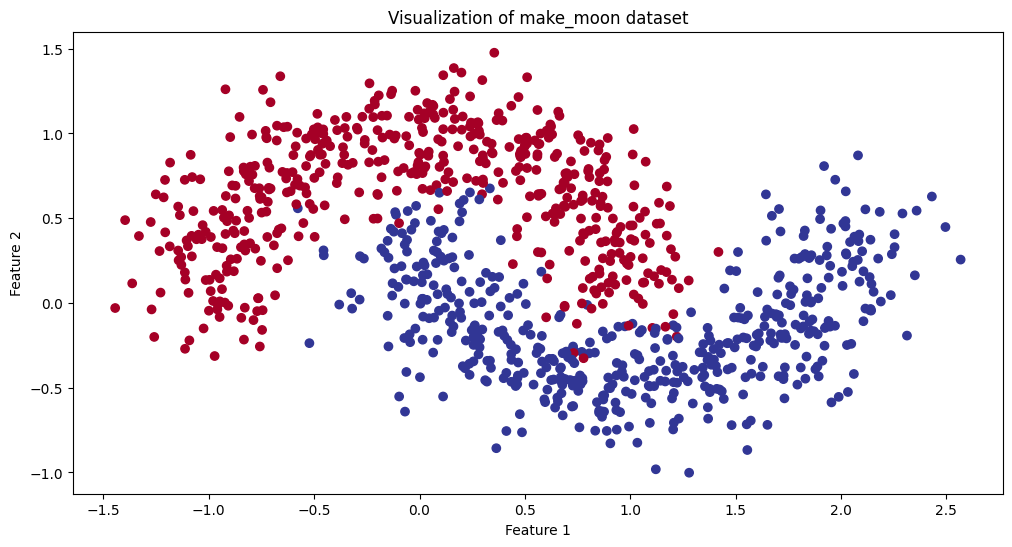

In [124]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(x=X_moon[:, 0],y=X_moon[:, 1], c=y_moon, cmap = plt.cm.RdYlBu)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Visualization of make_moon dataset")

In [125]:
class myTanh(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return ((torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x)))

In [126]:
# Creating the model

class ModelV0(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(in_features=input_features,out_features=hidden_units),
                             myTanh(),
                             nn.Linear(in_features=hidden_units, out_features=hidden_units),
                             myTanh(),
                             nn.Linear(in_features=hidden_units, out_features=hidden_units),
                             myTanh(),
                             nn.Linear(in_features=hidden_units, out_features=output_features))

  def forward(self, x):
    return self.net(x)

model_0 = ModelV0(input_features=2, output_features=1, hidden_units=8).to(device)
model_0

ModelV0(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): myTanh()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): myTanh()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): myTanh()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [127]:
## Creating loss fn and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [128]:
import requests
from pathlib import Path

url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
file_path = Path("helper_functions.py")

if file_path.is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py...")
    response = requests.get(url)
    response.raise_for_status()  # safety check

    file_path.write_bytes(response.content)
    print("Download complete ✅")


helper_functions.py already exists, skipping download


In [129]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right ?
def accuracy_fn(y_true, y_pred):

  correct = torch.eq(y_true, y_pred).sum().item()

  acc = (correct/len(y_pred)) * 100
  return acc

In [130]:
## Training and Testing Loop
epochs = 1000
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for epoch in range(epochs):

  # Training Phase
  model_0.train()
  y_logits = model_0(X_moon_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss and find the accuracy

  loss = loss_fn(y_logits,y_moon_train)
  acc = accuracy_fn(y_true=y_moon_train, y_pred=y_preds)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Move backward
  loss.backward()

  # Optimizer step
  optimizer.step()


  # Testing (we can say inference)
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_moon_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,y_moon_test)
    test_acc = accuracy_fn(y_true=y_moon_test, y_pred=test_preds)

  if epoch%100 == 0:
    print(f"Epoch: {epoch} | Train loss: {loss} | Accuracy: {acc}% | Test loss: {test_loss} | Test Accuracy {test_acc}%")


Epoch: 0 | Train loss: 0.7024737596511841 | Accuracy: 50.0% | Test loss: 0.7001103758811951 | Test Accuracy 50.0%
Epoch: 100 | Train loss: 0.3522753119468689 | Accuracy: 84.375% | Test loss: 0.36844155192375183 | Test Accuracy 81.5%
Epoch: 200 | Train loss: 0.30137211084365845 | Accuracy: 87.25% | Test loss: 0.3039897084236145 | Test Accuracy 86.5%
Epoch: 300 | Train loss: 0.29522499442100525 | Accuracy: 87.5% | Test loss: 0.29544907808303833 | Test Accuracy 86.5%
Epoch: 400 | Train loss: 0.2843526005744934 | Accuracy: 87.625% | Test loss: 0.28214168548583984 | Test Accuracy 86.5%
Epoch: 500 | Train loss: 0.25214919447898865 | Accuracy: 89.0% | Test loss: 0.2435455471277237 | Test Accuracy 89.0%
Epoch: 600 | Train loss: 0.17586563527584076 | Accuracy: 93.0% | Test loss: 0.15742722153663635 | Test Accuracy 93.5%
Epoch: 700 | Train loss: 0.11620263010263443 | Accuracy: 96.125% | Test loss: 0.09181293845176697 | Test Accuracy 97.5%
Epoch: 800 | Train loss: 0.0949455201625824 | Accuracy: 9

In [131]:
from helper_functions import plot_decision_boundary

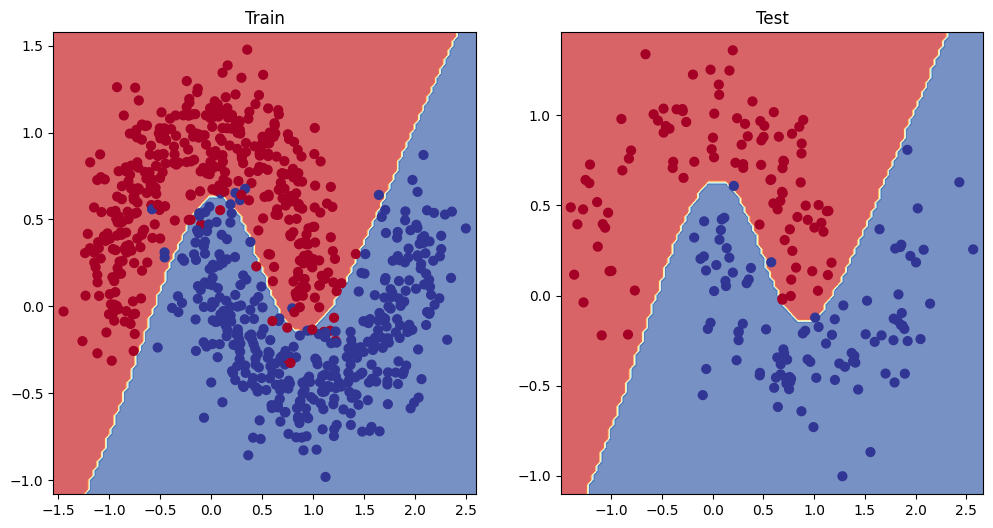

In [132]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_moon_train,y_moon_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_moon_test,y_moon_test)

In [133]:
def tanh(z):
  return ((torch.exp(x)-torch.exp(-z))/ (torch.exp(z)+torch.exp(-z)))

### Practice Question - 2

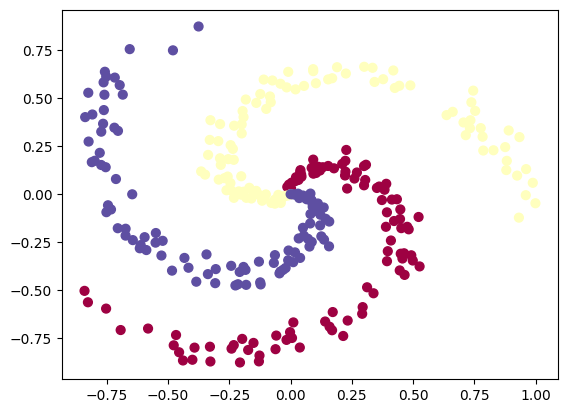

In [149]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [150]:
np.unique(y)

array([0, 1, 2], dtype=uint8)

In [151]:
X[:5], y[:5]

(array([[-0.        ,  0.        ],
        [ 0.00086968,  0.0100635 ],
        [ 0.00073689,  0.02018858],
        [ 0.00168579,  0.0302561 ],
        [-0.01366974,  0.03802137]]),
 array([0, 0, 0, 0, 0], dtype=uint8))

In [152]:
X = torch.tensor(X).type(torch.float)
y =torch.tensor(y).type(torch.LongTensor)

In [153]:
X[:5], y[:5]

(tensor([[-0.0000,  0.0000],
         [ 0.0009,  0.0101],
         [ 0.0007,  0.0202],
         [ 0.0017,  0.0303],
         [-0.0137,  0.0380]]),
 tensor([0, 0, 0, 0, 0]))

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(f"5 data points of training dataset is {X_train[:5]} and its shape {X_train.shape} and its label {y_train[:5]} and its shape {y_train.shape}")
print(f"5 data points of testing dataset is {X_test[:5]} and its shape {X_test.shape} and its label {y_test[:5]} and its shape {y_test.shape}")

5 data points of training dataset is tensor([[-0.0641, -0.3168],
        [ 0.4451, -0.3963],
        [ 0.0047,  0.0604],
        [ 0.8277,  0.2284],
        [ 0.3342,  0.6573]]) and its shape torch.Size([240, 2]) and its label tensor([2, 0, 0, 1, 1]) and its shape torch.Size([240])
5 data points of testing dataset is tensor([[ 0.0302,  0.0028],
        [-0.6119, -0.2646],
        [-0.1831,  0.4923],
        [ 0.0219,  0.0882],
        [ 0.0386, -0.3311]]) and its shape torch.Size([60, 2]) and its label tensor([2, 2, 1, 0, 2]) and its shape torch.Size([60])


In [155]:
# Device Agnostic code -
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [156]:
class  ModelV1(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=5):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(in_features=input_features,out_features=hidden_units),
                                         nn.ReLU(),
                                         nn.Linear(in_features=hidden_units, out_features=hidden_units),
                                         nn.ReLU(),
                                        nn.Linear(in_features=hidden_units, out_features=output_features))
  def forward(self,x):
    return self.net(x)

model_1 = ModelV1(input_features=2,output_features=3, hidden_units=5).to(device)

In [142]:
model_1

ModelV1(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)

In [158]:
# Optimizer and Loss function
optimizer = torch.optim.Adam(model_1.parameters(), lr = 0.1)
loss_fn = nn.CrossEntropyLoss()

In [144]:

y_logits = model_1(X_test)
y_logits[:5]

tensor([[ 0.0028, -0.0410,  0.2456],
        [-0.0006, -0.0670,  0.2184],
        [-0.0388, -0.0023,  0.2119],
        [-0.0036, -0.0333,  0.2419],
        [ 0.0132, -0.0827,  0.2532]], grad_fn=<SliceBackward0>)

In [145]:
pred_probs = torch.softmax(y_logits, dim=1)
pred_class = torch.argmax(pred_probs, dim=1)

In [146]:
pred_probs[:5]

tensor([[0.3094, 0.2961, 0.3945],
        [0.3144, 0.2942, 0.3914],
        [0.3010, 0.3122, 0.3868],
        [0.3078, 0.2988, 0.3934],
        [0.3145, 0.2857, 0.3998]], grad_fn=<SliceBackward0>)

In [147]:
pred_class[:10]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [159]:
# Training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train)
  y_preds = torch.argmax(y_logits, dim=1)
  acc = accuracy_fn(y_true=y_train,y_pred=y_preds)

  # Calculate the loss
  loss = loss_fn(y_logits,y_train)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Backward
  loss.backward()

  # Optimizer step
  optimizer.step()

  # Inference (Testing)
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test)
    test_preds = torch.argmax(test_logits, dim=1)
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_preds)


  # print what's happening
  if epoch%100 == 0:
    print(f" Epoch: {epoch} |Train Loss: {loss:.4f} | Train Acc: {acc:.4f}% | Test loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}%")




 Epoch: 0 |Train Loss: 1.0960 | Train Acc: 32.5000% | Test loss: 1.1120 | Test Acc: 26.6667%
 Epoch: 100 |Train Loss: 0.1032 | Train Acc: 97.5000% | Test loss: 0.1226 | Test Acc: 96.6667%
 Epoch: 200 |Train Loss: 0.0365 | Train Acc: 98.7500% | Test loss: 0.0570 | Test Acc: 98.3333%
 Epoch: 300 |Train Loss: 0.0291 | Train Acc: 98.7500% | Test loss: 0.0082 | Test Acc: 100.0000%
 Epoch: 400 |Train Loss: 0.0219 | Train Acc: 99.1667% | Test loss: 0.0552 | Test Acc: 96.6667%
 Epoch: 500 |Train Loss: 0.0199 | Train Acc: 99.1667% | Test loss: 0.0717 | Test Acc: 96.6667%
 Epoch: 600 |Train Loss: 0.0186 | Train Acc: 99.1667% | Test loss: 0.0747 | Test Acc: 96.6667%
 Epoch: 700 |Train Loss: 0.0176 | Train Acc: 99.1667% | Test loss: 0.0855 | Test Acc: 96.6667%
 Epoch: 800 |Train Loss: 0.0169 | Train Acc: 99.1667% | Test loss: 0.0801 | Test Acc: 96.6667%
 Epoch: 900 |Train Loss: 0.0168 | Train Acc: 99.1667% | Test loss: 0.0825 | Test Acc: 96.6667%


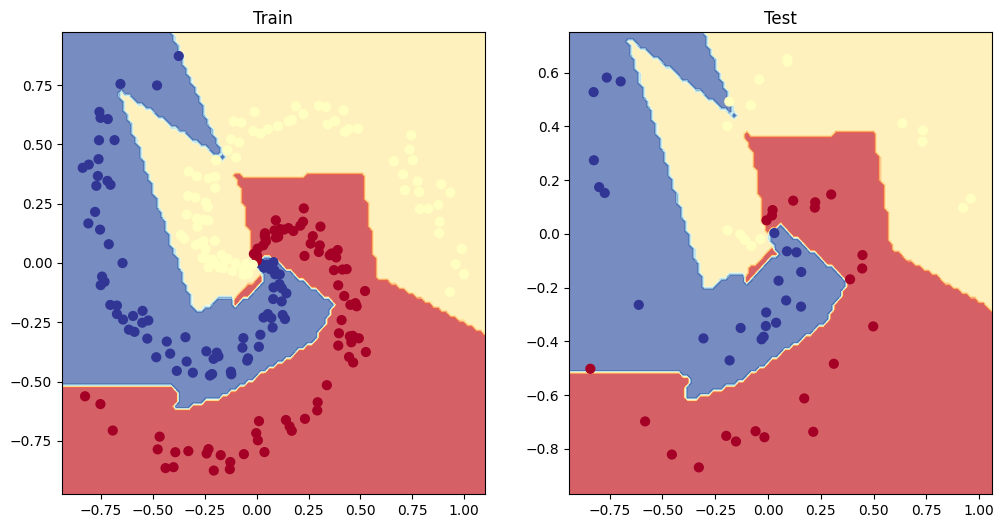

In [160]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test,y_test)